# Comparaison des resultats de AizynthFinder et de nos modeles

In [1]:
#Importations utiles 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [2]:
#Importations pour charger des modèles
import pickle
from aizynthfinder.utils.models import LocalKerasModel

In [3]:
import tqdm.notebook as tq
import SelectionGroup

In [7]:
#Noms des Fichiers
fname_fp_false = "Nom du Fichier de ValidationData pour les Fausses Reactions"
fname_fp_true = "Nom du Fichier de ValidationData pour les Vraies Reactions"

In [8]:
#Chargement des données
data_fp_false = pd.read_csv(fname_fp_false)
data_fp_true = pd.read_csv(fname_fp_true)

In [9]:
def fp_from_fp_db(fp_db):
    '''
    Cette fonction permet de recréer le fingerprint de taille 2048
    à partir du fingerprint codé en mémoire
    '''
    res = np.zeros(2048)
    #On initialise un array de 2048 zéros
    list_idx = fp_db.split(" ")
    #On récupère tous les indices non nuls du fingerprint
    for el in list_idx[:-1]:
        lfp = el.split("-")
        n = len(lfp)
        #En fonction des cas, on complète avec la bonne valeur
        if n == 1:
            res[int(lfp[0])] = 1
        elif n==2:
            res[int(lfp[0])] = int(lfp[-1])
        else:
            res[int(lfp[0])] = -int(lfp[-1])
    return res

def input_model_from_db(base_fp):
    '''
    Cette fonction renvoie un array de fingerprint à partir d'un dataset contenant des
    fingerprints sous forme "codée"
    '''
    #On sépare fingerprint de réactions et fingerprints du produit
    prod_fp_db,rxn_fp_db = base_fp["Product_Fingerprint"],base_fp["Reaction_Fingerprint"]
    prod_fp,rxn_fp = [],[]
    p_bar = tq.tqdm(total=base_fp.shape[0])
    for i in range(base_fp.shape[0]):
        #On essaie de récupérer le fingerprint associé à la ligne i
        try:
            p_bar.update(1)
            rxn_fp.append(fp_from_fp_db(rxn_fp_db.iloc[i]))
            prod_fp.append(fp_from_fp_db(prod_fp_db.iloc[i]))
        except:
            continue
    return np.array(prod_fp), np.array(rxn_fp)

In [10]:
size_true = data_fp_true.shape[0]
size_false = data_fp_false.shape[0]

In [11]:
p1,p2 = input_model_from_db(data_fp_true[:100000])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
p3,p4 = input_model_from_db(data_fp_false[:size_false*100000//size_true])

  0%|          | 0/13867 [00:00<?, ?it/s]

In [13]:
prod_fp = np.concatenate((p1, p3))

In [14]:
rxn_fp = np.concatenate((p2,p4))

In [15]:
labels = np.array([1]*p1.shape[0]+[0]*p3.shape[0])

In [16]:
input_test = [np.concatenate((rxn_fp[i], prod_fp[i])) for i in range(rxn_fp.shape[0])]

In [17]:
input_2_test = [np.concatenate((prod_fp[i]-rxn_fp[i], prod_fp[i])) for i in range(rxn_fp.shape[0])]

## Chargement des Modeles

In [19]:
reg_model = pickle.load(open("regression_model.sav", 'rb'))

In [20]:
rf_model = pickle.load(open("Random_Forest_model.sav", 'rb'))

In [ ]:
cnb_model = pickle.load(open("Complement_Bayesian_model.sav", 'rb'))

In [21]:
aizynth_model = LocalKerasModel("../uspto_filter_model.hdf5")

# Predictions

In [23]:
reg_pred = reg_model.predict(input_test)
reg_pred_prob = reg_model.predict_proba(input_test)
rf_pred = rf_model.predict(input_test)
cnb_pred = cnb_model.predict(input_2_test)

In [24]:
rf_pred_prob = rf_model.predict_proba(input_test)
cnb_pred_prob = cnb_model.predict_proba(input_2_test)

In [25]:
aizynth_pred = aizynth_model.model.predict([prod_fp_test, rxn_fp_test])

In [46]:
aizynth_pred2 = aizynth_model.model.predict([rxn_fp_test, prod_fp_test])

## Resultats

In [28]:
fpr_reg, tpr_reg, _ = roc_curve(labels_test, reg_pred_prob[:,1])
fpr_rf, tpr_rf, _ = roc_curve(labels_test, rf_pred_prob[:,1])
fpr_cnb, tpr_cnb, _ = roc_curve(labels_test, cnb_pred_prob[:,1])
fpr_ai, tpr_ai, _ = roc_curve(labels_test, aizynth_pred2)

In [30]:
print(f"AiZynthFinder : {score(labels_test, rf_pred,pos_label=1, average='binary')}")
print(f"RandomForest : {score(labels_test, reg_pred, pos_label=1, average='binary')}")
print(f"RegressionLogistique : {score(labels_test, cnb_pred, pos_label=1, average='binary')}")
print(f"CNB : {score(labels_test, cnb_pred, pos_label=1, average='binary')}")
      

AiZynthFinder : (0.9532437730076014, 0.9977981284091477, 0.9750122249388753, None)
RandomForest : (0.9573728772084373, 0.9789320922784367, 0.9680324623911322, None)
RegressionLogistique : (0.969735182849937, 0.8466196266826803, 0.9040049159742445, None)
CNB : (0.969735182849937, 0.8466196266826803, 0.9040049159742445, None)


In [31]:
def tp_tn_fp_fn(y,y2):
    #assert(y.shape == y2.shape)
    n = y.shape[0]
    return n-np.nonzero(y+y2-2)[0].shape[0], n-np.nonzero(y+y2)[0].shape[0], n-np.nonzero(y2-y+1)[0].shape[0], n-np.nonzero(-y2+y+1)[0].shape[0]

In [32]:
def str_tp(y,y2):
    tp,tn,fp,fn = tp_tn_fp_fn(y,y2)
    n = tp+tn+fp+fn
    return f"TP : {tp/n}, TN : {tn/n}, FP : {fp/n}, FN : {fn/n}"

In [33]:
print(f"AiZynthFinder : {score(labels_test, rf_pred,pos_label=1, average='binary')}")
print(f"RandomForest : {score(labels_test, reg_pred, pos_label=1, average='binary')}")
print(f"RegressionLogistique : {score(labels_test, cnb_pred, pos_label=1, average='binary')}")
print(f"CNB : {score(labels_test, cnb_pred, pos_label=1, average='binary')}")

AiZynthFinder : (0.9532437730076014, 0.9977981284091477, 0.9750122249388753, None)
RandomForest : (0.9573728772084373, 0.9789320922784367, 0.9680324623911322, None)
RegressionLogistique : (0.969735182849937, 0.8466196266826803, 0.9040049159742445, None)
CNB : (0.969735182849937, 0.8466196266826803, 0.9040049159742445, None)


In [34]:
print(f"AiZynthFinder : {str_tp(labels_test, rf_pred)} ")
print(f"RandomForest : {str_tp(labels_test, reg_pred)}")
print(f"RegressionLogistique : {str_tp(labels_test, cnb_pred)}")
print(f"CNB : {str_tp(labels_test, np.array([x[0] for x in aizynth_pred]))}")
     

AiZynthFinder : TP : 0.8779832672831351, TN : 0.07701453104359313, FP : 0.001937472479084104, FN : 0.043064729194187586 
RandomForest : TP : 0.8613826508146191, TN : 0.0817261118450022, FP : 0.018538088947600177, FN : 0.038353148392778515
RegressionLogistique : TP : 0.744958168207838, TN : 0.09682959048877146, FP : 0.13496257155438132, FN : 0.023249669749009248
CNB : TP : 0.9863636363636363, TN : 0.0, FP : 0.0, FN : 0.013636363636363636


In [49]:
auc_1 = roc_auc_score(labels_test, reg_pred_prob[:,1])
auc_2 = roc_auc_score(labels_test, rf_pred_prob[:,1])
auc_3 = roc_auc_score(labels_test, aizynth_pred2)
auc_4 = roc_auc_score(labels_test, cnb_pred_prob[:,1])

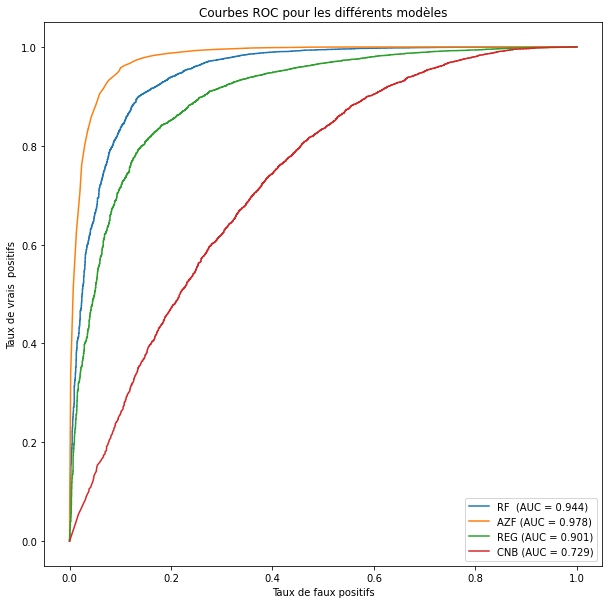

In [50]:
plt.figure(figsize=(10,10))
plt.plot(fpr_rf,tpr_rf, label=f"RF  (AUC = {np.round(auc_2,3)})")
plt.plot(fpr_ai, tpr_ai, label=f"AZF (AUC = {np.round(auc_3,3)})")
plt.plot(fpr_reg, tpr_reg, label=f"REG (AUC = {np.round(auc_1,3)})")
plt.plot(fpr_cnb, tpr_cnb,label=f"CNB (AUC = {np.round(auc_4,3)})")
plt.legend(loc="best")
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais  positifs')
plt.title('Courbes ROC pour les différents modèles')
plt.savefig('ROC_Curves_Models_Init.png')